# Self-Supervised GAN

## Importing Libraries

In [1]:
!pip install -q pytorch-fid

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tqdm
import os
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
from pytorch_fid import fid_score
from torch.nn.utils.parametrizations import spectral_norm
import torch.nn.functional as F
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting up the GPU

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Preprocessing the Images

In [4]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Loading the Dataset

In [5]:
batch_size = 2

In [6]:
dataset = datasets.MNIST(root='./data/train', train=True, download=True, transform=transform)
subset_indices = range(10000)
subset_test_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:19<00:00, 508791.13it/s]


Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48454277.53it/s]


Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74863513.71it/s]

Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 9665412.87it/s]


Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



## Generator Network

In [7]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [8]:
class GeneratorResidual(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GeneratorResidual, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        
        self.adjust_channels = nn.Upsample(scale_factor=4, mode='nearest')

    def forward(self, z):
        block1 = self.block1(z)
        layerInput = self.adjust_channels(z)
        return block1 + layerInput # Skip Connection

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),
            Reshape((-1, 256, 4, 4)),  # Reshape to be in 4D
            nn.BatchNorm2d(256),

            GeneratorResidual(256, 256),  
            GeneratorResidual(256, 256),
            GeneratorResidual(256, 256),  

            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        return z

## Discriminator Network

In [10]:
class DiscriminatorResidual(nn.Module):
    def __init__(self, in_channels, out_channels, first_block=False, down_sampling=False):
        super(DiscriminatorResidual, self).__init__()

        self.first_block = first_block
        self.down_sampling = down_sampling

        self.relu = nn.ReLU()
        self.conv1b1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        self.conv2b1 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        self.avgpoolb1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
            
        self.avgpoolb2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
        self.conv3b2 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        b2in = x
        if self.first_block:
            block1 = self.relu(self.conv1b1(x))
            block1 = self.conv2b1(block1)
            if self.down_sampling:
                block1 = self.avgpoolb1(block1)
        else:
            block1 = self.relu(x)
            block1 = self.relu(self.conv1b1(block1))
            block1 = self.conv2b1(block1)
            if self.down_sampling:
                block1 = self.avgpoolb1(block1)

        if self.down_sampling:        
            b2in = self.avgpoolb2(b2in)
        block2 = self.conv3b2(b2in)

        return block1 + block2

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ssup=True, num_rotation = 4):
        super(Discriminator, self).__init__()
        self.ssup = ssup 
        
        self.residualBlocks = nn.Sequential(
            DiscriminatorResidual(1, 128, first_block=True, down_sampling=True),
            DiscriminatorResidual(128, 128, down_sampling=True),
            DiscriminatorResidual(128, 128),
            DiscriminatorResidual(128, 128),
        )
        
        self.adversarialLayer = nn.Sequential(
            nn.Linear(128, 1),
        )
        self.auxiliaryLayer = nn.Sequential(
            nn.Linear(128, num_rotation)
        )
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.residualBlocks(x)
        features = torch.sum(features, dim=(2, 3))
        adv_out = self.adversarialLayer(features)
        if self.ssup:
            rot_out = self.auxiliaryLayer(features)
            rot_prob = self.softmax(rot_out)
            return self.sigmoid(adv_out), adv_out, rot_out, rot_prob
        else:
            return self.sigmoid(adv_out), adv_out
            

## SSGAN Loss

In [ ]:
class SSGANLoss:
    def __init__(self, a=0.5, b=1.0):
        self.a = a
        self.b = b

    def rotation_loss(self, y_true, y_pred):
        criterion = nn.CrossEntropyLoss()
        return criterion(y_pred, y_true)
    

    def generator_loss(self, D_fake, D_rot, rot_labels):
        # Adversarial Loss for generator
        G_loss_adversarial = torch.mean(F.softplus(-D_fake))        
        # Rotation Loss for generator
        G_loss_rotation = self.rotation_loss(rot_labels, D_rot)
        # Total Generator Loss with coefficients
        G_loss = - G_loss_adversarial + self.a * G_loss_rotation
        return G_loss

    def discriminator_loss(self, D_real, D_fake, D_rot, rot_labels):
        # Adversarial Loss for real and fake images
        D_loss_real = torch.mean(D_real)
        D_loss_fake = torch.mean(F.softplus(-D_fake))
        # Total Adversarial Loss
        D_loss = D_loss_real + D_loss_fake
        # Auxiliary Rotation Loss
        D_rot_loss = self.rotation_loss(rot_labels, D_rot)
        # Total Loss
        loss = D_loss + self.b * D_rot_loss
        return loss

### Noise Generation from Normal Distribution

In [13]:
def generate_noise(batch_size, latent_dim=128):
    return torch.randn(batch_size, latent_dim).to(device)

### Initialize Models and Loss

In [14]:
ss_losses = SSGANLoss()

In [15]:
generator = Generator()
discriminator = Discriminator()
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)
generator = generator.to(device)
discriminator = discriminator.to(device)
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

DataParallel(
  (module): Generator(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=4096, bias=True)
      (1): Reshape()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GeneratorResidual(
        (block1): Sequential(
          (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Upsample(scale_factor=2.0, mode='nearest')
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Upsample(scale_factor=2.0, mode='nearest')
        )
        (adjust_channels): Upsample(scale_factor=4.0, mode='nearest')
      )
      (4): GeneratorResidual(
        (block1): Sequential(
          (0): BatchNorm2d(256, ep

### Set Loss and Optimizer

In [16]:
lr = 0.0002
beta1 = 0.0
beta2 = 0.99

In [17]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

## Training the Model

In [18]:
def plot_losses(losses_G, losses_D):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_D, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [19]:
def plot_generated_images(generator, epoch, epochs):
    with torch.no_grad():
        fake_images = generator(generate_noise(100)).detach().cpu()
    fake_images = fake_images.view(-1, 1, 256, 256)
    #vutils.save_image(fake_images, f"gan_samples_epoch_{epoch}.png" ,nrow=10, normalize=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(vutils.make_grid(fake_images, nrow=10, normalize=True).permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Generated Images From Epoch {epoch + 1} / {epochs}")
    plt.show()

In [20]:
num_epochs = 15

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], D Loss: 0.705377995967865, G Loss: -0.6931471824645996


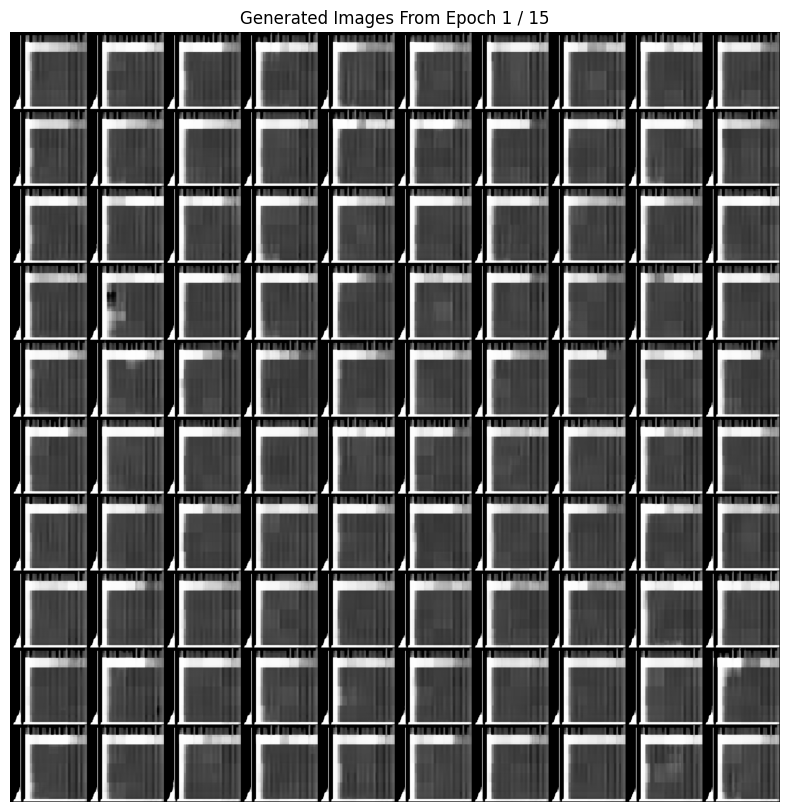

 13%|█▎        | 2/15 [42:00<4:32:51, 1259.32s/it]

Epoch [2/15], D Loss: 0.7000482082366943, G Loss: -0.6931471824645996


 20%|██        | 3/15 [1:02:49<4:10:53, 1254.48s/it]

Epoch [3/15], D Loss: 0.7070268988609314, G Loss: -0.6931471824645996


 27%|██▋       | 4/15 [1:23:37<3:49:31, 1251.97s/it]

Epoch [4/15], D Loss: 0.7087118625640869, G Loss: 0.07497292757034302


 33%|███▎      | 5/15 [1:44:23<3:28:17, 1249.75s/it]

Epoch [5/15], D Loss: 0.3134720027446747, G Loss: -0.3132617175579071


 40%|████      | 6/15 [2:05:08<3:07:13, 1248.15s/it]

Epoch [6/15], D Loss: 0.3164346516132355, G Loss: -0.3132617175579071


 47%|████▋     | 7/15 [2:25:52<2:46:15, 1246.98s/it]

Epoch [7/15], D Loss: 0.5262981057167053, G Loss: -0.3132617175579071


 53%|█████▎    | 8/15 [2:46:35<2:25:18, 1245.54s/it]

Epoch [8/15], D Loss: 0.31490227580070496, G Loss: -0.3132617175579071


 60%|██████    | 9/15 [3:07:18<2:04:29, 1244.90s/it]

Epoch [9/15], D Loss: 0.31522849202156067, G Loss: -0.3132617175579071


 67%|██████▋   | 10/15 [3:28:03<1:43:43, 1244.70s/it]

Epoch [10/15], D Loss: 0.3135070204734802, G Loss: -0.3132617175579071


 73%|███████▎  | 11/15 [3:48:45<1:22:56, 1244.16s/it]

Epoch [11/15], D Loss: 0.32216817140579224, G Loss: -0.3132617175579071


 80%|████████  | 12/15 [4:09:33<1:02:15, 1245.31s/it]

Epoch [12/15], D Loss: 0.31378620862960815, G Loss: -0.3132617175579071


 87%|████████▋ | 13/15 [4:30:12<41:26, 1243.38s/it]  

Epoch [13/15], D Loss: 0.3282022476196289, G Loss: -0.3132617175579071


 93%|█████████▎| 14/15 [4:50:42<20:39, 1239.20s/it]

Epoch [14/15], D Loss: 0.31577637791633606, G Loss: -0.3132617175579071


100%|██████████| 15/15 [5:11:12<00:00, 1244.82s/it]

Epoch [15/15], D Loss: 0.5534244775772095, G Loss: -0.3132617175579071


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_26/2403723619.py", line 20, in forward
    z = self.model(z)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_26/1734017547.py", line 22, in forward
    return block1 + layerInput # Skip Connection
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB (GPU 0; 14.75 GiB total capacity; 7.68 GiB already allocated; 1.90 GiB free; 12.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [21]:
losses_G = []
losses_D = []

for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        size = real_images.shape[0]
        real_images = real_images.to(device)
        
        # Rotate generated and real images in 4 angles
        x = real_images
        x_real = x
        x_90, x_180, x_270 = x.transpose(2,3), x.flip(2,3), x.transpose(2,3).flip(2,3)
        real_images = torch.cat((x, x_90, x_180, x_270), 0)
        
        z = generate_noise(size)
        fake_images = generator(z)
        x = fake_images
        x_fake = x
        x_90, x_180, x_270 = x.transpose(2,3), x.flip(2,3), x.transpose(2,3).flip(2,3)
        fake_images = torch.cat((x, x_90, x_180, x_270), 0)
        
        # Discriminator on real and fake rotated images
        output_real, _, output_rot_real, prob_rot_real = discriminator(real_images)
        output_fake, _, output_rot_fake, prob_rot_fake = discriminator(fake_images)
        
        #rot_pred_logits = output_rot_real.view(4 * size, -1)
        rot_labels = torch.zeros(4 * size, device=device, dtype=torch.long)
        rot_labels[size:2 * size] = 1
        rot_labels[2 * size:3 * size] = 2
        rot_labels[3 * size:] = 3

        # Train Discriminator
        optimizer_D.zero_grad()
        loss_D = ss_losses.discriminator_loss(output_real, output_fake, output_rot_real, rot_labels)
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = generate_noise(size)
        fake_images = generator(z)
        x = fake_images
        x_90, x_180, x_270 = x.transpose(2,3), x.flip(2,3), x.transpose(2,3).flip(2,3)
        fake_images = torch.cat((x, x_90, x_180, x_270), 0)
        output_fake, _, output_rot_fake, prob_rot_fake = discriminator(fake_images)
        rot_pred_logits = output_rot_fake.view(4 * size, -1)
        loss_G = ss_losses.generator_loss(output_fake, output_rot_fake, rot_labels)
        loss_G.backward(retain_graph=True)
        optimizer_G.step()

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {loss_D.item()}, G Loss: {loss_G.item()}")

    # Save generated images at initial and medial intervals
    if epoch == num_epochs/2 or epoch == 0:
        plot_generated_images(generator, epoch, num_epochs)

# Save the final generated images
plot_generated_images(generator, epoch, num_epochs)

In [ ]:
plot_losses(losses_G, losses_D)

## Evaluating the Model

###  Load the MNIST Test Dataset

In [ ]:
batch_size = 2
mnist_test_dataset = datasets.MNIST(root="./data/test", train=False, download=True, transform=transform)
subset_indices = range(1000)
subset_test_dataset = Subset(mnist_test_dataset, subset_indices)
test_dataloader = DataLoader(subset_test_dataset, batch_size=batch_size, shuffle=True)

#### Real Images

In [ ]:
import torchvision.utils
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
os.makedirs("real_images", exist_ok=True)
for i, (images, labels) in enumerate(test_dataloader):
    for j in range(images.size(0)):
        img = transform(images[j].squeeze())
        filename = f"{i * batch_size + j}.png"
        img_path = os.path.join("real_images", filename)
        torchvision.utils.save_image(img, img_path)

In [ ]:
real_images_path = "real_images"

#### Fake Images

In [ ]:
num_samples = len(test_dataloader.dataset)
os.makedirs("fake_images", exist_ok=True)
with torch.no_grad():
    for i in range(num_samples // batch_size):
        z = generate_noise(batch_size)
        fake_batch = generator(z)
        for j in range(fake_batch.size(0)):
            img = transform(fake_batch[j].squeeze())
            filename = f"{i * batch_size + j}.png"
            img_path = os.path.join("fake_images", filename)
            torchvision.utils.save_image(img, img_path)

In [ ]:
fake_images_path = "fake_images" 

### Calculate Fréchet Inception Distance (FID) Score

In [ ]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=batch_size, dims=2048, device=device)
print(f"FID Score: {fid_value}")